# Info

This script fits Fermi data using Gaussian functions. 

Uses:
- lmfit

-----------------------
Created by Jerry LaRue, larue@chapman.edu, 9/2018

Last modified by Jerry LaRue, larue@chapman.edu, 07/2019

# Initialize

In [1]:
import numpy as np
from pandas import DataFrame as df
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, Layout
from IPython.display import clear_output
import pylab as plb
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import lmfit
from lmfit import model
from lmfit.models import GaussianModel, LinearModel, VoigtModel, PolynomialModel
import sys

sys.path.insert(0, '../src/')

import analysis_tools

##### Definitions #####

def FileList() :
    return [f for f in listdir(FolderPath.value) if isfile(join(FolderPath.value, f))]

def UpdateFileList(b) :
    FolderPath.value = FolderPath.value.replace('\\','/')
    Data_Name.options = FileList()
    Background_Name.options = FileList()

def ParametersToClipboard_Clicked(b):
    ToCopy = analysis_tools.Convert2Dataframe(Fit_Parameters)
    ToCopy.to_clipboard()

##### Default parameters #####

Data_Default = 'XAS_014_014_bin_50.h5'
Background_Default = 'XAS_099_099_bin.h5'
FolderPath_Default = '../../Binned/BT2/'

##### Select file #####

FolderPath = widgets.Text(
    value=FolderPath_Default,
    placeholder='Type file path',
    description='Folder',
    layout=Layout(width='80%'),
    style = {'description_width': '150px'},
    disabled=False
)

Data_Name = widgets.Dropdown(
    options=FileList(),
    value=Data_Default,
    description='Data',
    layout=Layout(width='80%'),
    style = {'description_width': '150px'},
    disabled=False,
)

Background_Name = widgets.Dropdown(
    options=FileList(),
    value=Background_Default,
    description='Background',
    layout=Layout(width='80%'),
    style = {'description_width': '150px'},
    disabled=False,
)

BackgroundFit = widgets.Checkbox(
    value=False,
    description='Use fit?',
    layout=Layout(width='10%'),
    style = {'description_width': '10px'},
    disabled=False
)

button_UpdateFileList = widgets.Button(description="Update")
button_UpdateFileList.on_click(UpdateFileList)

display(widgets.Box([FolderPath,button_UpdateFileList]))
display(Data_Name)
display(widgets.Box([Background_Name,BackgroundFit]))

Box(children=(Text(value='../../Binned/BT2/', description='Folder', layout=Layout(width='80%'), placeholder='T…

Dropdown(description='Data', index=13, layout=Layout(width='80%'), options=('XAS_000_000_bin_1000.h5', 'XAS_00…

Box(children=(Dropdown(description='Background', index=26, layout=Layout(width='80%'), options=('XAS_000_000_b…

# Load data

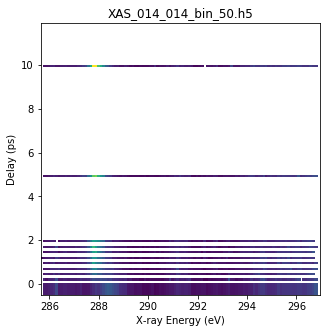

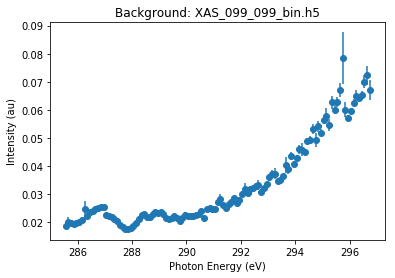

Box(children=(BoundedFloatText(value=286.5, description='ROI Min:', layout=Layout(width='20%'), max=310.0, min…

Box(children=(BoundedFloatText(value=7.0, description='Number of Peaks:', layout=Layout(width='20%'), max=10.0…

In [34]:
Energy, Signal, Delay, ErrorBars = analysis_tools.ImportData(FolderPath.value,Data_Name.value)

##### Plot data #####

plt.figure(figsize = [5,5])
plt.pcolor(Energy, Delay*1e-3, Signal)
plt.xlabel('X-ray Energy (eV)')
plt.ylabel('Delay (ps)')
plt.title(Data_Name.value)
plt.show()

if Background_Name.value != 'None' :
    
    Background_Energy, Background, Background_Delay, Background_ErrorBars = analysis_tools.ImportData(FolderPath.value,Background_Name.value)

    # Check data structure

    if Background.shape[0] != 1 :
        raise HaltException('Background data exceeds allowed dimensions')
    
    ##### Plot background data #####
    
    x = Background_Energy
    y = Background[0]
    err = Background_ErrorBars[0]
    plt.plot(x, y,'r.', label='data')
    plt.errorbar(x, y, yerr=err, fmt='o')
    plt.xlabel('Photon Energy (eV)'), plt.ylabel('Intensity (au)')
    plt.title('Background: '+Background_Name.value)
    
    ##### Fit positive delay data #####
    
    if BackgroundFit.value == True :
        Model = PolynomialModel(4)
        Params = Model.make_params(c0=55, c1=-0.4,
                                c2=0.001, c3=0.001, c4=0.01,c5=0.01)
        Fit = Model.fit(y, Params, x=x)
        Comps = Fit.eval_components(Fit.params, x=x)
        Background_Fit = Comps['polynomial']
        plt.plot(x, Comps['polynomial'], 'k--', label='Baseline')

    plt.show()

##### Display widgets #####

ROI_Min = widgets.BoundedFloatText(
    value=286.5,
    min=280,
    max=310,
    step=0.1,
    description='ROI Min:',
    layout=Layout(width='20%'),
    disabled=False
)

ROI_Max = widgets.BoundedFloatText(
    value=291,
    min=280,
    max=310,
    step=0.1,
    description='ROI Max:',
    layout=Layout(width='20%'),
    disabled=False
)

NumberPeaks = widgets.BoundedFloatText(
    value=7,
    min=1,
    max=10,
    step=1,
    description='Number of Peaks:',
    layout=Layout(width='20%'),
    style = {'description_width': '130px'},
    disabled=False
)

NumRefPeaks = widgets.BoundedFloatText(
    value=1,
    min=0,
    max=2,
    step=1,
    description='Number of Reference Peaks:',
    layout=Layout(width='25%'),
    style = {'description_width': '170px'},
    disabled=False
)

display(widgets.Box([ROI_Min,ROI_Max]))
display(widgets.Box([NumberPeaks,NumRefPeaks]))

# Fit data

Background Successfully subtracted from data


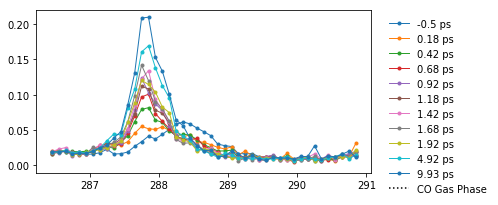

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.5936, Slope: -0.002<p>Peak 1 |&nbsp; Amplitude:…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.7144, Slope: -0.0024<p>Peak 1 |&nbsp; Amplitude…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.7471, Slope: -0.0025<p>Peak 1 |&nbsp; Amplitude…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.738, Slope: -0.0025<p>Peak 1 |&nbsp; Amplitude:…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.4537, Slope: -0.0015<p>Peak 1 |&nbsp; Amplitude…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.6677, Slope: -0.0023<p>Peak 1 |&nbsp; Amplitude…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.6291, Slope: -0.0021<p>Peak 1 |&nbsp; Amplitude…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.6302, Slope: -0.0021<p>Peak 1 |&nbsp; Amplitude…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.5714, Slope: -0.0019<p>Peak 1 |&nbsp; Amplitude…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.6986, Slope: -0.0024<p>Peak 1 |&nbsp; Amplitude…

______________________________________________________________________________________________________________


Box(children=(Output(), HTML(value='<p>Baseline | Intercept: 0.2351, Slope: -0.0008<p>Peak 1 |&nbsp; Amplitude…

______________________________________________________________________________________________________________


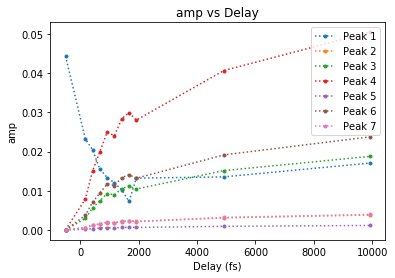

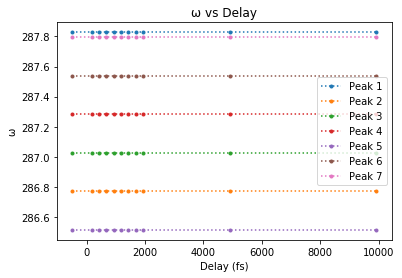

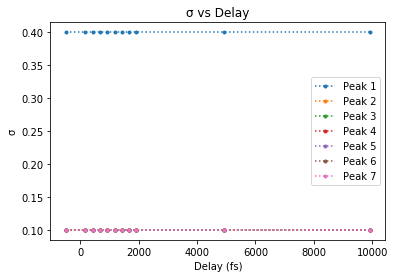

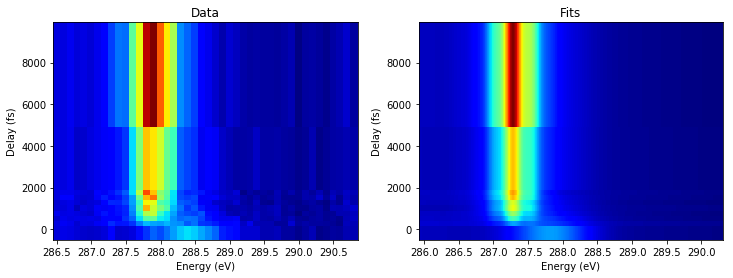

Button(description='Copy parameters', style=ButtonStyle())

In [35]:
##### Prepare data #####

Energy, Signal, Delay, ErrorBars = analysis_tools.ImportData(FolderPath.value,Data_Name.value)
Energy, Signal, Delay, ErrorBars = analysis_tools.TrimData(Energy,Signal,Delay,ErrorBars,ROI_Min.value,ROI_Max.value)
if Background_Name.value != 'None' :
    if BackgroundFit.value == 'Fit' :
        Signal = analysis_tools.SubtractBackground(Energy,Signal,Background_Energy,Background_Fit,ROI_Min.value,ROI_Max.value)
    else :
        Signal = analysis_tools.SubtractBackground(Energy,Signal,Background_Energy,Background,ROI_Min.value,ROI_Max.value)

Fit_Parameters = np.zeros((len(Delay),(3+3*int(NumberPeaks.value))))

plt.figure(figsize = [6,3])
i = 0
while i < len(Signal) :
    plt.plot(Energy,Signal[i],'-o', ms=3, lw=1,label=(str(round(Delay[i]*1e-3,2))+' ps'))
    i+= 1
plt.plot((287.3,287.3),(0,max(y)),'k:',label='CO Gas Phase')
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(1.2, 1), ncol=1)
plt.show()

print('_'*110)

##### Fit data #####

i = 0
while i < len(Delay) :
    
    ##### Remove NaNs #####
    
    remove = np.argwhere(np.isnan(Signal[i]))
    x = np.delete(Energy,remove)
    y = np.delete(Signal[i],remove)
    err = np.delete(ErrorBars[i],remove)
    x = x - 0.53
    
    ##### Determine fit function #####
    
    Model = analysis_tools.FitModel(NumberPeaks.value)
    Params = Model.make_params()
    
    ##### Define constraints #####
    
    Params['B_slope'].value = 0
    Params['B_slope'].vary = True
    Params['B_intercept'].value = 0
    Params['B_intercept'].vary = True
    Params['G1_amplitude'].value = 0.03
    Params['G1_amplitude'].min = 0
    Params['G1_center'].value = 287.8
    Params['G1_center'].min = 287
    Params['G1_center'].vary = True
    Params['G1_sigma'].value = 0.3
    Params['G1_sigma'].max = 0.4
    Params['G1_sigma'].vary = True
    if NumberPeaks.value >= 2 :
        Params['G2_amplitude'].value = 0
        Params['G2_amplitude'].vary = True
        Params['G2_amplitude'].min = 0
        Params['G2_center'].value = 286.77
        Params['G2_center'].vary = False
        Params['G2_sigma'].value = 0.1
        Params['G2_sigma'].vary = False
    if NumberPeaks.value >= 3 :
#         Params['G3_amplitude'].value = 0.01
        Params['G3_amplitude'].set(expr='G2_amplitude/0.2024')
        Params['G3_amplitude'].min = 0
        Params['G3_amplitude'].vary = True
        Params['G3_center'].set(expr='G2_center+0.256')
        Params['G3_center'].vary = False
        Params['G3_sigma'].value = 0.1
        Params['G3_sigma'].vary = False
    if NumberPeaks.value >= 4 : # 287.76 eV peak corresponds to peak in CO/Ru(0001) -> Gas phase CO?
#         Params['G4_amplitude'].value = 0.0
        Params['G4_amplitude'].set(expr='G2_amplitude/0.0753249')
        Params['G4_amplitude'].vary = True
        Params['G4_amplitude'].min = 0
        Params['G4_center'].set(expr='G2_center+2*0.256')
        Params['G4_center'].vary = False
        Params['G4_sigma'].value = 0.1
        Params['G4_sigma'].vary = False
    if NumberPeaks.value >= 5 : # 288 eV peak corresponds to peak in CO/Ru(0001) -> Tilted CO?
#         Params['G5_amplitude'].value = 0.01
        Params['G5_amplitude'].set(expr='G2_amplitude/3.352807209')
        Params['G5_amplitude'].min = 0
        Params['G5_center'].set(expr='G2_center-0.256')
        Params['G5_center'].vary = False
        Params['G5_sigma'].value = 0.1
        Params['G5_sigma'].vary = False
    if NumberPeaks.value >= 6 :
#         Params['G6_amplitude'].value = 0.0
        Params['G6_amplitude'].set(expr='G2_amplitude/0.16')
        Params['G6_amplitude'].min = 0
        Params['G6_amplitude'].vary = True
        Params['G6_center'].set(expr='G2_center+3*0.256')
        Params['G6_center'].vary = False
        Params['G6_sigma'].value = 0.1
        Params['G6_sigma'].vary = False
    if NumberPeaks.value >= 7 :
#         Params['G7_amplitude'].value = 0.0
        Params['G7_amplitude'].set(expr='G2_amplitude/0.96095513')
        Params['G7_amplitude'].min = 0
        Params['G7_amplitude'].vary = True
        Params['G7_center'].set(expr='G2_center+4*0.256')
        Params['G7_center'].vary = False
        Params['G7_sigma'].value = 0.1
        Params['G7_sigma'].vary = False
    if NumberPeaks.value >= 8 :
        Params['G8_amplitude'].value = 0.0
#         Params['G8_amplitude'].set(expr='G2_amplitude/0.96095513')
        Params['G8_amplitude'].min = 0
        Params['G8_amplitude'].vary = True
        Params['G8_center'].set(expr='G2_center+5*0.256')
        Params['G8_center'].vary = False
        Params['G8_sigma'].value = 0.1
        Params['G8_sigma'].vary = False
    
    # Reference delay
    if NumRefPeaks.value >= 1 :
        if i == 0 :
            if NumberPeaks.value >= 2 :
                Params['G2_amplitude'].value = 0
                Params['G2_amplitude'].vary = False
            if NumberPeaks.value >= 3 :
                Params['G3_amplitude'].value = 0
                Params['G3_amplitude'].vary = False
            if NumberPeaks.value >= 4 :
                Params['G4_amplitude'].value = 0
                Params['G4_amplitude'].vary = False
            if NumberPeaks.value >= 5 :
                Params['G5_amplitude'].value = 0
                Params['G5_amplitude'].vary = False
            if NumberPeaks.value >= 6 :
                Params['G6_amplitude'].value = 0
                Params['G6_amplitude'].vary = False
        else :
            Params['G1_amplitude'].value = Fit_Parameters[0,3]
            Params['G1_center'].value = Fit_Parameters[0,4]
            Params['G1_center'].vary = False
            Params['G1_sigma'].value = Fit_Parameters[0,5]
            Params['G1_sigma'].vary = False
#     if NumRefPeaks.value >= 2 :
#         if i == 0 :
#             Params['G2_amplitude'].vary = True
#         else :
#             Params['G2_amplitude'].set(expr='G1_amplitude * '+str(Fit_Parameters[0,6]/Fit_Parameters[0,3]))
#             Params['G2_center'].value = Fit_Parameters[0,7]
#             Params['G2_center'].vary = False
#             Params['G2_sigma'].value = Fit_Parameters[0,8]
#             Params['G2_sigma'].vary = False
    
    ##### Fit the data #####
    
    Fit = Model.fit(y, Params, x=x, fit_kws={'maxfev': 10000})
#     print(Fit.fit_report())
    Fit_Parameters[i], fit_x, fit_y = analysis_tools.Fits(x,y,err,Delay[i],Fit)
    if i == 0 :
        Fit_Energy = fit_x
        Fit_Signal = np.zeros((len(Delay),len(fit_y)))
    Fit_Signal[i] = fit_y
    i += 1
    
    print('_'*110)

Fit_Parameters = analysis_tools.Convert2Dataframe(Fit_Parameters)
analysis_tools.PlotAnalysis('amp',Fit_Parameters)
analysis_tools.PlotAnalysis('ω',Fit_Parameters)
analysis_tools.PlotAnalysis('σ',Fit_Parameters)
analysis_tools.PlotDataAndFits(Energy, Signal, Fit_Energy, Fit_Signal, Delay)

ParametersToClipboard = widgets.Button(description="Copy parameters")
ParametersToClipboard.on_click(ParametersToClipboard_Clicked)
display(ParametersToClipboard)